#Pro Sports Transaction

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------
# Scraping Configuration
# -----------------------------
BaseURL = "https://www.prosportstransactions.com/basketball/Search/SearchResults.php?Player=&Team=&BeginDate=&EndDate=&ILChkBx=yes&Submit=Search&start=39825"
EndURL = "https://www.prosportstransactions.com/basketball/Search/SearchResults.php?Player=&Team=&BeginDate=&EndDate=&ILChkBx=yes&Submit=Search&start=41775"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
}

In [ ]:
# -----------------------------
# Scraper Functions
# -----------------------------
def updateURL(URL):
    match = re.search(r'start=(\d+)', URL)
    if match:
        lastNum = match.group(1)
        updatedLastNum = int(lastNum) + 25
        return URL.replace(f"start={lastNum}", f"start={updatedLastNum}")
    else:
        raise ValueError("No 'start=' parameter found in the URL.")


def HTMLtoPandas(startURL):
    all_dfs = []
    current_url = startURL

    while True:
        try:
            print(f"Current URL: {current_url}")
            response = requests.get(current_url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "lxml")
            temp_table = pd.read_html(str(soup))

            if not temp_table:
                break

            temp_df = temp_table[0].iloc[1:]
            all_dfs.append(temp_df)
            current_url = updateURL(current_url)

            if current_url == EndURL:
                break

        except Exception as e:
            print(f"Stopped at {current_url} due to {e}")
            break

    return pd.concat(all_dfs, ignore_index=True)

In [ ]:
# -----------------------------
# Preprocessing Functions
# -----------------------------
def addColNames(df, column_names):
    df.columns = column_names
    return df

def removeBulletPoints(df, column_names):
    for column in column_names:
        df[column] = df[column].str.replace('• ', '', regex=False)
    return df

def removeNanValues(df):
    return df.fillna({'Acquired': 0, 'Reliquinshed': 0})

def categorize_injury(note):
    note = str(note).lower()
    if any(word in note for word in ["out for season"]):
        return "major_injury"
    elif any(word in note for word in ["leg","ankle","knee", "hamstring","groin","achilles", "foot", "hip", "toe", "pelvic", "tibia", "gluteal", "thigh", "adductor", "quadriceps", "heel", "shin"]):
        return "lower"
    elif any(word in note for word in ["elbow", "shoulder","back", "cervical", "forearm","calf", "oblique","neck", "rib", "spine", "abdominal", "lambar", "hernia"]):
        return "upper"
    elif any(word in note for word in ["illness"]):
        return "non-body"
    elif any(word in note for word in ["thumb", "finger", "hand", "wrist"]):
        return "hand"
    elif "activated from il" in note:
        return "returned_from_injury"
    else:
        return "other"

def resolve_player(row):
    note = row["Notes"].lower()
    if "placed on il" in note and pd.notna(row["Relinquished"]):
        return row["Relinquished"]
    elif "activated from il" in note and pd.notna(row["Acquired"]):
        return row["Acquired"]
    return pd.NA

In [ ]:
# -----------------------------
# Labeling and Analysis
# -----------------------------
def generate_injury_next_n_days(df, window_days=7):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    injury_events = df[df["IsInjuredToday"] == 1]
    injury_map = injury_events.groupby("Player")["Date"].apply(list).to_dict()

    def label_row(row):
        player = row["Player"]
        current_date = row["Date"]
        if pd.isna(player) or pd.isna(current_date):
            return 0
        for inj_date in injury_map.get(player, []):
            if 0 < (pd.to_datetime(inj_date) - current_date).days <= window_days:
                return 1
        return 0

    df[f"InjuryNext{window_days}Days"] = df.apply(label_row, axis=1)
    return df

def get_total_injury_counts(df):
    injured_df = df[df["IsInjuredToday"] == 1]
    return (
        injured_df.groupby("Player")
        .size()
        .reset_index(name="TotalInjuries")
    )

In [ ]:
# -----------------------------
# Plotting Functions
# -----------------------------
def plotValueCounts(count, title):
    count.plot(kind='bar')
    plt.title(f"{title}")
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

def plot_injury_histogram(injury_counts_df, title="Distribution of Player Injury Counts"):
    count_distribution = injury_counts_df["TotalInjuries"].value_counts().sort_index()
    plt.figure(figsize=(10, 5))
    bars = plt.bar(count_distribution.index, count_distribution.values)
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=8)
    plt.title(title)
    plt.xlabel("Number of Times Injured")
    plt.ylabel("Number of Players")
    plt.xticks(count_distribution.index)
    plt.tight_layout()
    plt.show()

<ipython-input-4-015f3f1cf399>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.replace('• ', '', regex=False)


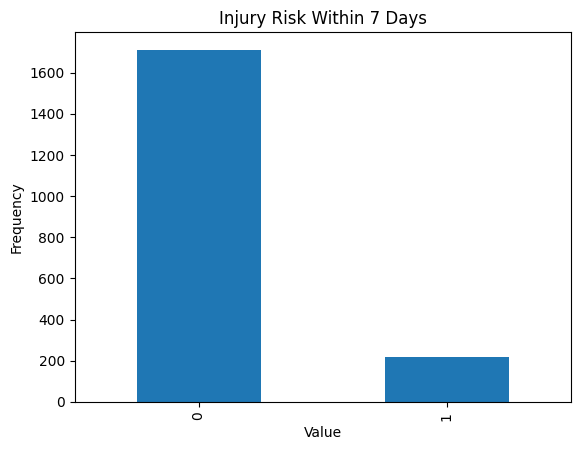

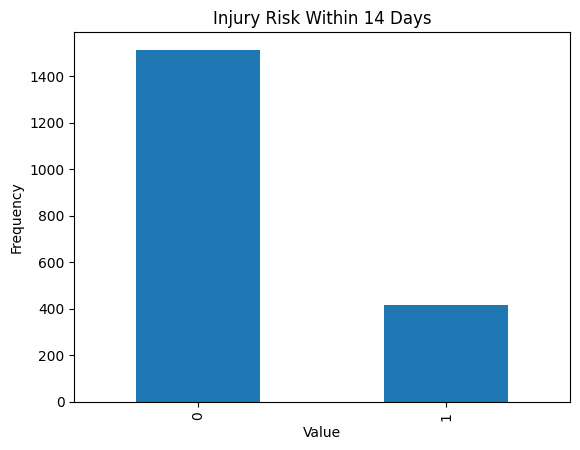

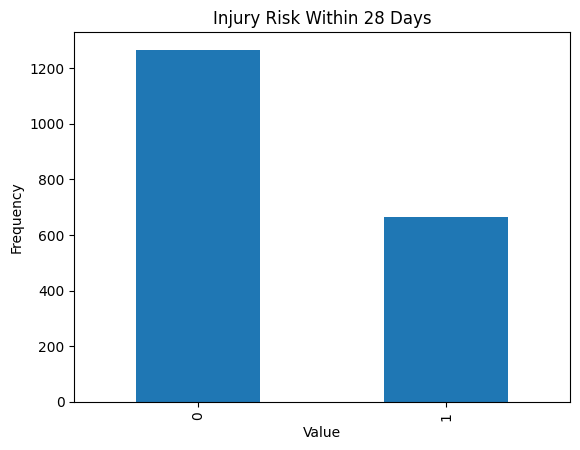

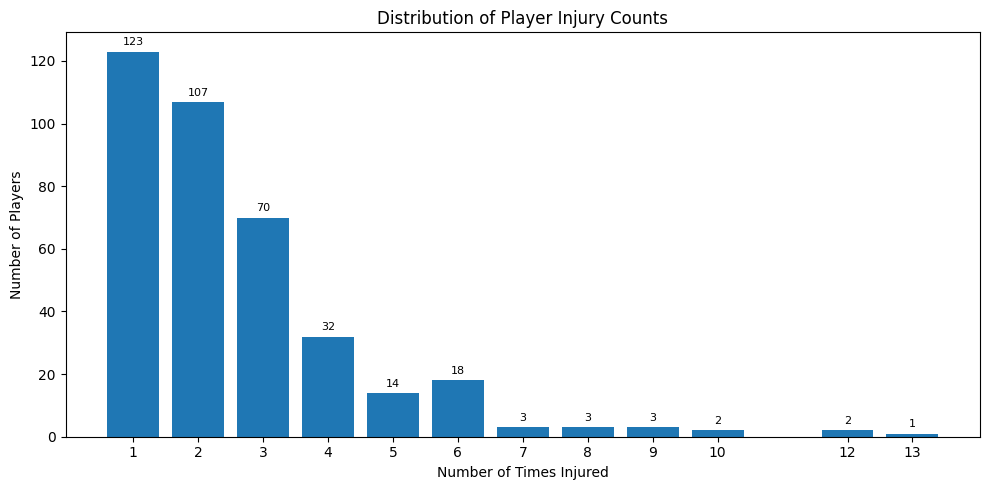

,Player,TotalInjuries
0,A.J. Green,3
1,A.J. Johnson,1
2,Aaron Gordon,10
3,Aaron Nesmith,2
4,Aaron Wiggins,1
5,Adam Flagler,1
6,Adama Sanogo,3
7,Adem Bona,2
8,Ajay Mitchell,1
9,Al Horford,6


In [ ]:
# -----------------------------
# Main Logic
# -----------------------------
webscrape_flag = False
if webscrape_flag:
    df = HTMLtoPandas("https://www.prosportstransactions.com/basketball/Search/SearchResults.php?Player=&Team=&BeginDate=&EndDate=&ILChkBx=yes&Submit=Search&start=0")
    df.to_csv('output.csv', index=False)
else:
    df = pd.read_csv('output.csv')

df = addColNames(df, ["Date", "Team", "Acquired", "Relinquished", "Notes"])

# ✅ Date filtering AFTER column renaming
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df = df[df["Date"] >= pd.Timestamp("2024-10-01")]

df = removeBulletPoints(df, ["Acquired", "Relinquished"])
df = removeNanValues(df)

df["InjuryCategory"] = df["Notes"].apply(categorize_injury)
df["Notes"] = df["Notes"].astype(str)
df["IsInjuredToday"] = df["Notes"].str.contains("placed on IL", case=False, na=False).astype(int)
df["IsReturningToday"] = df["Notes"].str.contains("activated from IL", case=False, na=False).astype(int)
df["Player"] = df.apply(resolve_player, axis=1)

# Generate injury targets (future windows)
df_7days = generate_injury_next_n_days(df)
plotValueCounts(df_7days['InjuryNext7Days'].value_counts(), "Injury Risk Within 7 Days")
df_7days.to_csv("output_refined_7days.csv", index=False)

df_14days = generate_injury_next_n_days(df, window_days=14)
plotValueCounts(df_14days['InjuryNext14Days'].value_counts(), "Injury Risk Within 14 Days")
df_14days.to_csv("output_refined_14days.csv", index=False)

df_28days = generate_injury_next_n_days(df, window_days=28)
plotValueCounts(df_28days['InjuryNext28Days'].value_counts(), "Injury Risk Within 28 Days")
df_28days.to_csv("output_refined_28days.csv", index=False)

# Plot total injury histogram
injury_counts_df = get_total_injury_counts(df)
plot_injury_histogram(injury_counts_df)

# Final result
sports_transactions_df = injury_counts_df
sports_transactions_df.head(50)

#NBA Stats Parser


In [ ]:
import pandas as pd

#Load the cleaned season stats
df = pd.read_csv("PlayerStats2024_2025_Cleaned.csv")

Convert Minutes Played (MP) to numeric
df["MP"] = pd.to_numeric(df["MP"], errors="coerce")

Extract combined entries (2TM / 3TM rows)
combined_entries = df[df["Team"].isin(["2TM", "3TM"])].copy()

#Replace '2TM'/'3TM' with the player's most recent team
for idx, row in combined_entries.iterrows():
    player_name = row["Player"]
    individual_rows = df[
        (df["Player"] == player_name) &
        (~df["Team"].isin(["2TM", "3TM"]))
    ]
    if not individual_rows.empty:
        most_recent_team = individual_rows.iloc[-1]["Team"]
        combined_entries.at[idx, "Team"] = most_recent_team

#Drop all individual team rows for players who have combined entries
non_combined = df[~df["Team"].isin(["2TM", "3TM"])]
non_combined = non_combined[~non_combined["Player"].isin(combined_entries["Player"])]

#Recombine the cleaned dataset
final_df = pd.concat([non_combined, combined_entries], ignore_index=True)

#Drop any rows where team is blank or missing
final_df = final_df[final_df["Team"].str.strip() != ""]

nba_teams = [
    "ATL", "BOS", "BRK", "CHI", "CHO", "CLE", "DAL", "DEN", "DET", "GSW",
    "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", "MIN", "NOP", "NYK",
    "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "TOR", "UTA", "WAS"
]
final_df = final_df[final_df["Team"].isin(nba_teams)]

#Get Top 10 players per team by minutes played
top_10_per_team_df = (
    final_df.groupby("Team", group_keys=False)
    .apply(lambda x: x.sort_values(by="MP", ascending=False).head(10))
    .reset_index(drop=True)
)

#Save the Top 10 per team (300 players total)
top_10_per_team_df.to_csv("Top10Players_PerTeam_CLEANED.csv", index=False)

print("Top 10 players per team exported: Top10Players_PerTeam_CLEANED.csv")


✅ Top 10 players per team exported: Top10Players_PerTeam_CLEANED.csv


<ipython-input-8-e46946b39940>:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values(by="MP", ascending=False).head(10))


#Merge the Frames

In [ ]:
import pandas as pd
import re

#Load data
injury_df = pd.read_csv("output_refined_14days.csv")
top_300_df = pd.read_csv("Top10Players_PerTeam_CLEANED.csv")

#Clean 'Player' names in injury data
def clean_injury_player_name(name):
    if pd.isna(name):
        return name
    name = name.split("/")[0].strip()
    name = re.sub(r"\(.*?\)", "", name)
    return name.strip()

injury_df["Player"] = injury_df["Player"].apply(clean_injury_player_name)
injury_df["Date"] = pd.to_datetime(injury_df["Date"], errors="coerce")
injury_df = injury_df.sort_values(["Player", "Date"]).reset_index(drop=True)

#Compute real injury durations (Start → End or April 13 if out for season)
#Compute real injury durations (Start → End or April 13 if no return)
injury_periods = []
season_end = pd.to_datetime("2025-04-13")

for player, group in injury_df.groupby("Player"):
    group = group.reset_index(drop=True)
    i = 0
    while i < len(group):
        row = group.iloc[i]
        note = str(row["Notes"]).lower()

        if note.startswith("placed on il"):
            start_date = row["Date"]
            end_date = None

            # Look for next "activated from IL"
            for j in range(i + 1, len(group)):
                next_note = str(group.iloc[j]["Notes"]).lower()
                if next_note.startswith("activated from il"):
                    end_date = group.iloc[j]["Date"]
                    break

            # NEW: fallback if no return found — assume still injured until April 13
            if end_date is None:
                end_date = season_end

            duration = (end_date - start_date).days
            injury_periods.append({
                "Player": player,
                "StartDate": start_date,
                "EndDate": end_date,
                "DaysInjuredReal": duration,
                "InjuryNote": row["Notes"]
            })

        i += 1


# Create DataFrame from real injury periods
duration_df = pd.DataFrame(injury_periods)
duration_summary = duration_df.groupby("Player")["DaysInjuredReal"].sum().reset_index()

#Aggregate additional injury stats
injury_summary = (
    injury_df[injury_df["IsInjuredToday"] == 1]
    .groupby("Player")
    .agg(
        NumTimesInjured=("IsInjuredToday", "count"),
        InjuryCategories=("InjuryCategory", lambda x: ", ".join(sorted(set(x.dropna())))),
    )
    .reset_index()
)

# Merge in real injury durations
injury_summary = injury_summary.merge(duration_summary, on="Player", how="left")

#Clean names in Top 10 players (just in case)
top_300_df["Player"] = top_300_df["Player"].str.strip()

#Merge injury summary into top 300 dataset
final_merged_df = top_300_df.merge(injury_summary, on="Player", how="left")

#Fill NaNs for players with no injury record
final_merged_df["NumTimesInjured"] = final_merged_df["NumTimesInjured"].fillna(0).astype(int)
final_merged_df["InjuryCategories"] = final_merged_df["InjuryCategories"].fillna("None")
final_merged_df["DaysInjuredReal"] = final_merged_df["DaysInjuredReal"].fillna(0).astype(int)

# Save to new CSV
final_merged_df.to_csv("Top10Players_WithRealInjuryDurations.csv", index=False)

print("✅ Final file saved: 'Top10Players_WithRealInjuryDurations.csv'")


✅ Final file saved: 'Top10Players_WithRealInjuryDurations.csv'


<ipython-input-10-3693629d8013>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=injured_players_per_team.index, y=injured_players_per_team.values, palette="Reds_r")


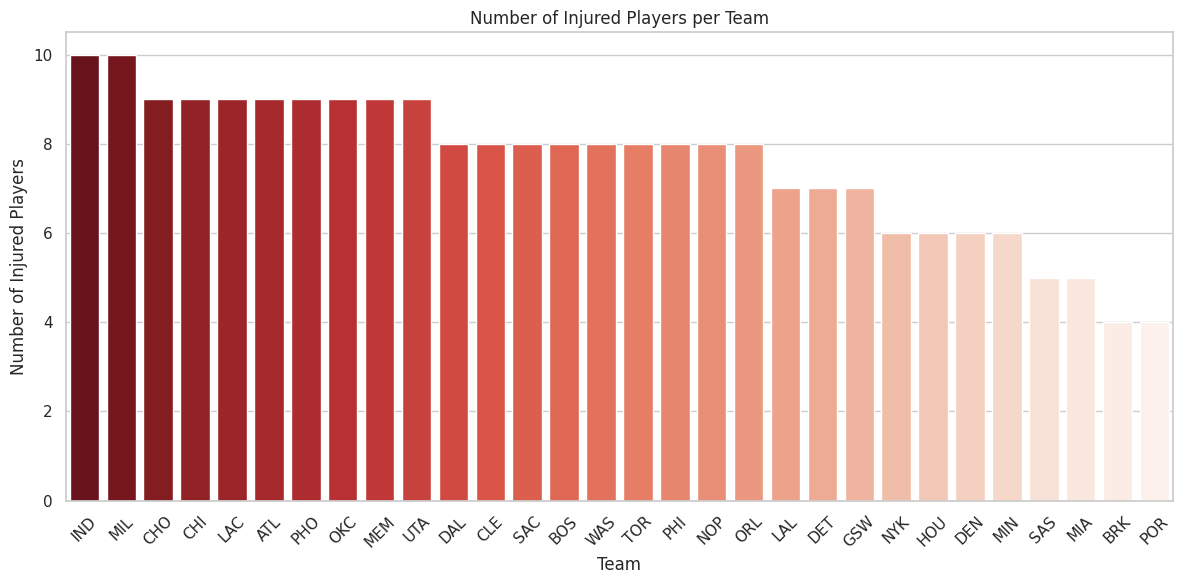

<ipython-input-10-3693629d8013>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days_injured_real_per_team.index, y=days_injured_real_per_team.values, palette="Blues_r")


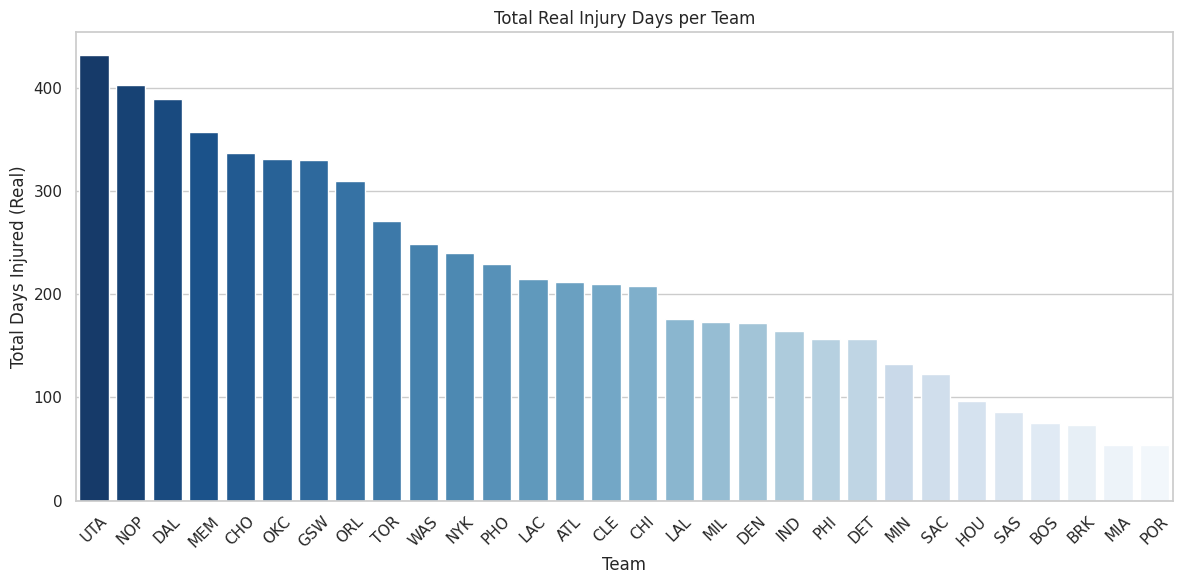

<ipython-input-10-3693629d8013>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DaysInjuredReal", y="Player", data=top_real_durations, palette="coolwarm")


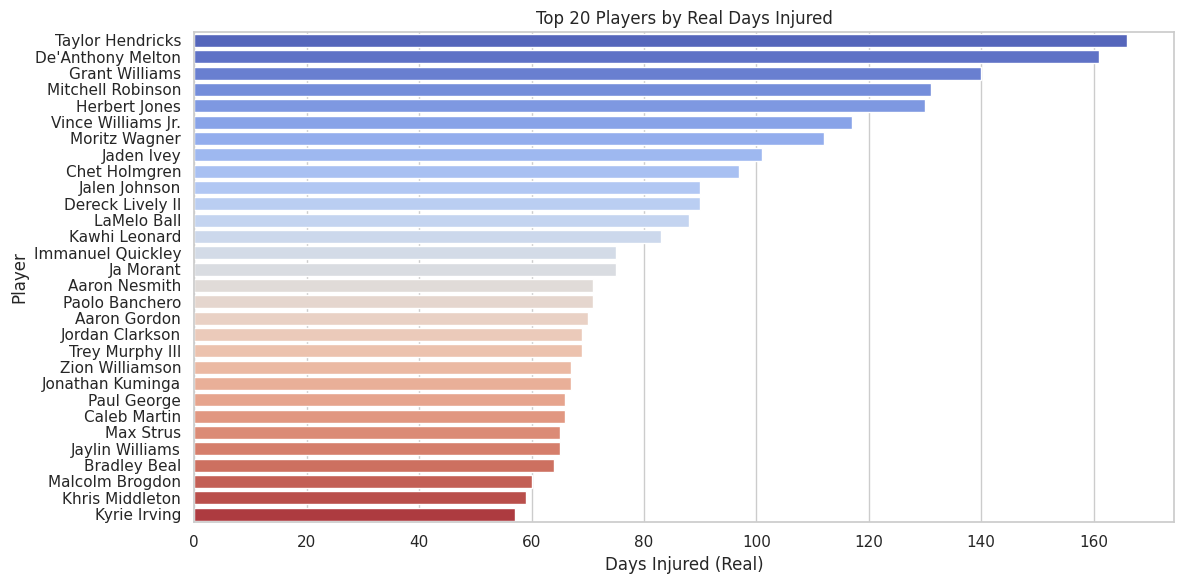

<ipython-input-10-3693629d8013>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="NumTimesInjured", y="Player", data=top_injuries, palette="magma")


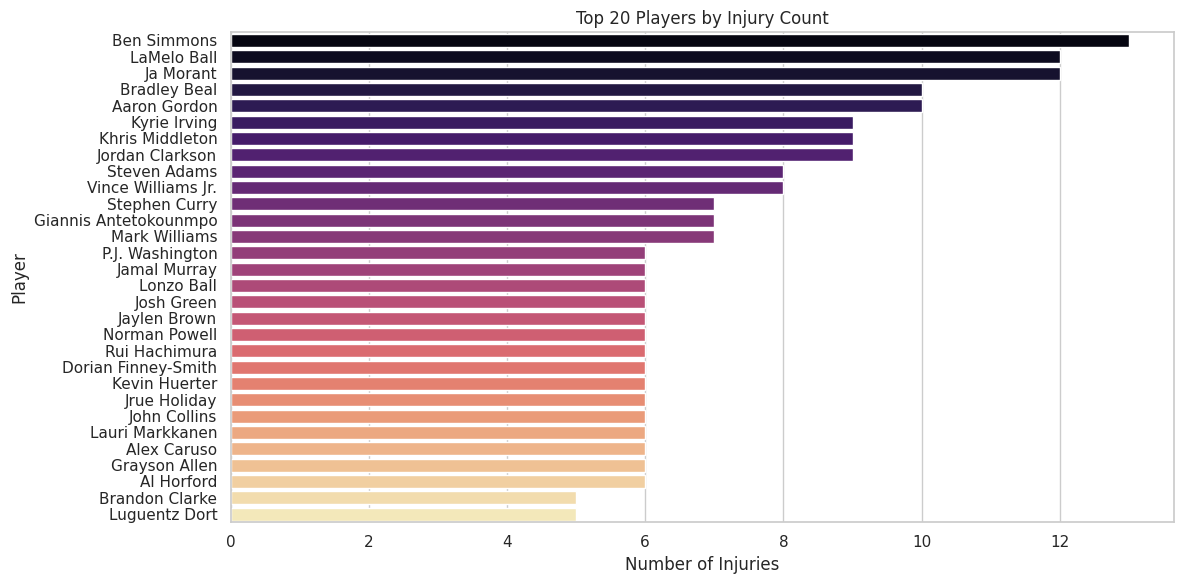

<ipython-input-10-3693629d8013>:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


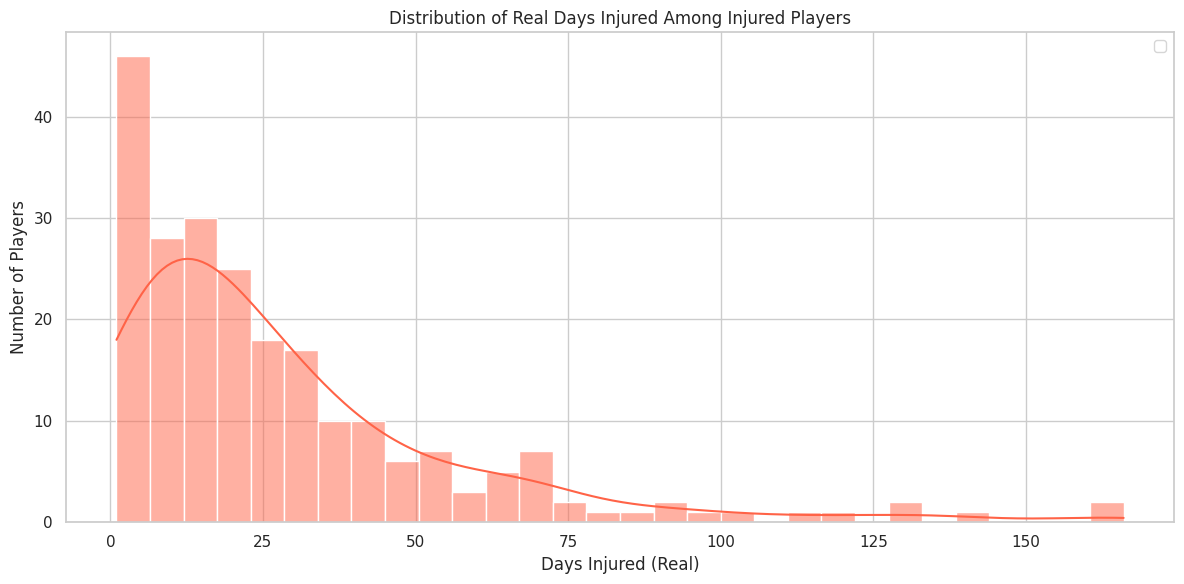

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final dataset with real durations
df = pd.read_csv("Top10Players_WithRealInjuryDurations.csv")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- Plot 1: Team vs Number of Injured Players ---
injured_players_per_team = df[df["NumTimesInjured"] > 0].groupby("Team")["Player"].nunique()
injured_players_per_team = injured_players_per_team.sort_values(ascending=False)

plt.figure()
sns.barplot(x=injured_players_per_team.index, y=injured_players_per_team.values, palette="Reds_r")
plt.title("Number of Injured Players per Team")
plt.xlabel("Team")
plt.ylabel("Number of Injured Players")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("NumberOfInjuredPlayersPerTeam.png")
plt.show()

# --- Plot 2: Team vs Total Real Injury Days ---
days_injured_real_per_team = df.groupby("Team")["DaysInjuredReal"].sum().sort_values(ascending=False)

plt.figure()
sns.barplot(x=days_injured_real_per_team.index, y=days_injured_real_per_team.values, palette="Blues_r")
plt.title("Total Real Injury Days per Team")
plt.xlabel("Team")
plt.ylabel("Total Days Injured (Real)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("TotalRealInjuryDaysPerTEam.png")
plt.show()

# --- Plot 3: Top 20 Players by Real Injury Duration ---
top_real_durations = df[df["DaysInjuredReal"] > 0].sort_values(by="DaysInjuredReal", ascending=False).head(30)

plt.figure()
sns.barplot(x="DaysInjuredReal", y="Player", data=top_real_durations, palette="coolwarm")
plt.title("Top 20 Players by Real Days Injured")
plt.xlabel("Days Injured (Real)")
plt.ylabel("Player")
plt.tight_layout()
plt.savefig("Top20PlayersByRealDaysInjured.png")
plt.show()

# --- Plot 4: Top 20 Players by Injury Count ---
top_injuries = df[df["NumTimesInjured"] > 0].sort_values(by="NumTimesInjured", ascending=False).head(30)

plt.figure()
sns.barplot(x="NumTimesInjured", y="Player", data=top_injuries, palette="magma")
plt.title("Top 20 Players by Injury Count")
plt.xlabel("Number of Injuries")
plt.ylabel("Player")
plt.tight_layout()
plt.savefig("Top20PlayersByinjuryCoutn.png")
plt.show()

# --- Plot 5: Distribution of Real Days Injured (Histogram) ---
injured_days = df["DaysInjuredReal"].dropna()
injured_days = injured_days[injured_days > 0]

plt.figure()
sns.histplot(injured_days, bins=30, kde=True, color="tomato")
plt.title("Distribution of Real Days Injured Among Injured Players")
plt.xlabel("Days Injured (Real)")
plt.ylabel("Number of Players")
plt.legend()
plt.tight_layout()

plt.show()

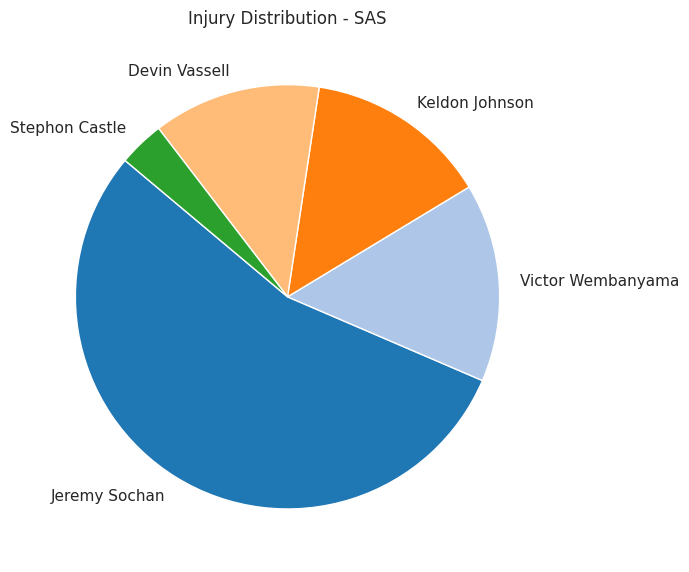

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Top10Players_WithRealInjuryDurations.csv")

#
injured_df = df[df["DaysInjuredReal"] > 0]

# ---- FUNCTION TO PLOT PIE CHART FOR SPECIFIC TEAM ----
def plot_team_injury_pie(team_code):
    team_df = injured_df[injured_df["Team"] == team_code]

    if team_df.empty:
        print(f"No injury data found for team: {team_code}")
        return

    # Sort by DaysInjuredReal to group small slices
    team_df = team_df.sort_values("DaysInjuredReal", ascending=False)

    plt.figure(figsize=(7, 7))
    plt.pie(
        team_df["DaysInjuredReal"],
        labels=team_df["Player"],
        startangle=140,
        colors=plt.cm.tab20.colors  # Consistent, visually pleasing palette
    )
    plt.title(f"Injury Distribution - {team_code}")
    plt.tight_layout()
    plt.show()

plot_team_injury_pie("SAS")


In [ ]:
num_injured_players = df[df["NumTimesInjured"] > 0]["Player"].nunique()


In [ ]:
num_injured_players

227

<ipython-input-14-cd837bf363ab>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=severity_counts.index, y=severity_counts.values,


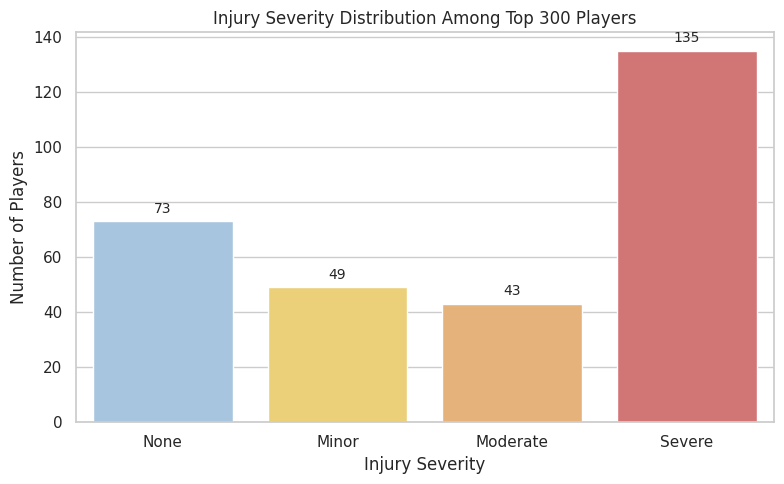

<ipython-input-14-cd837bf363ab>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="InjurySeverity", y="Height_in", palette="pastel")


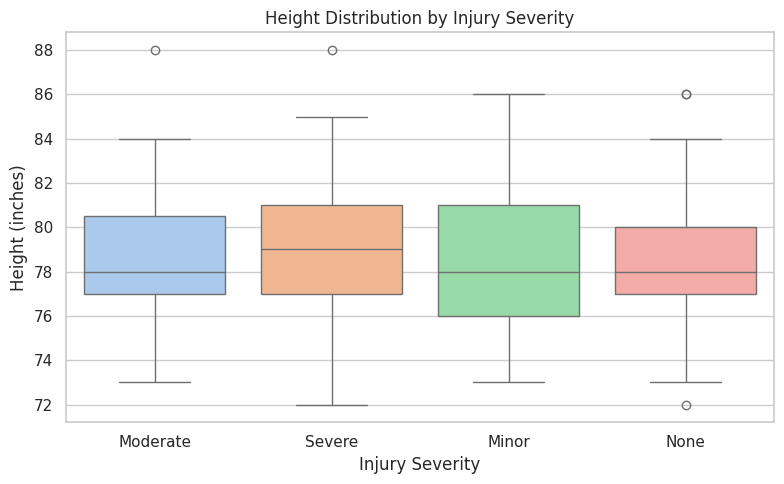

<ipython-input-14-cd837bf363ab>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="InjurySeverity", y="Weight_lb", palette="pastel")


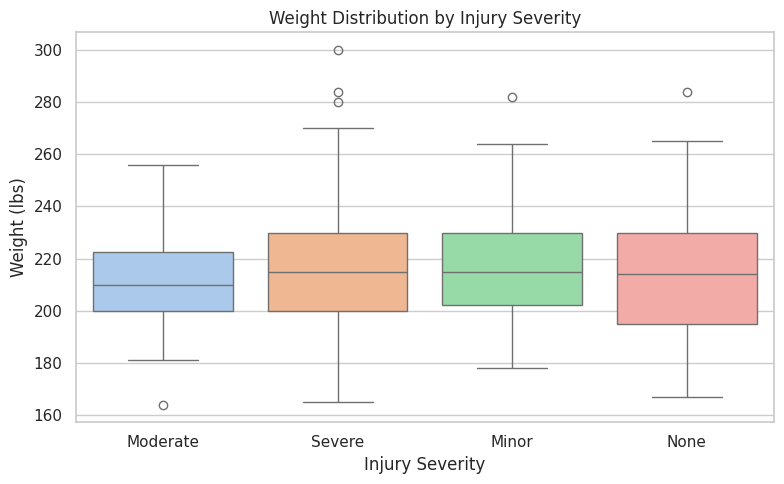

<ipython-input-14-cd837bf363ab>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x="InjuryCategories", y="Height_in", palette="Set2")


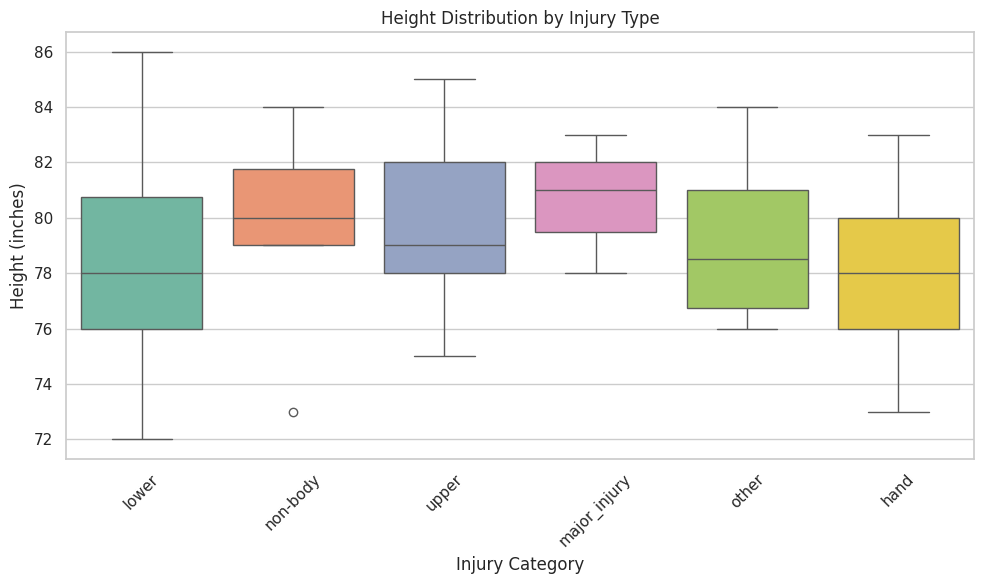

<ipython-input-14-cd837bf363ab>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x="InjuryCategories", y="Weight_lb", palette="Set3")


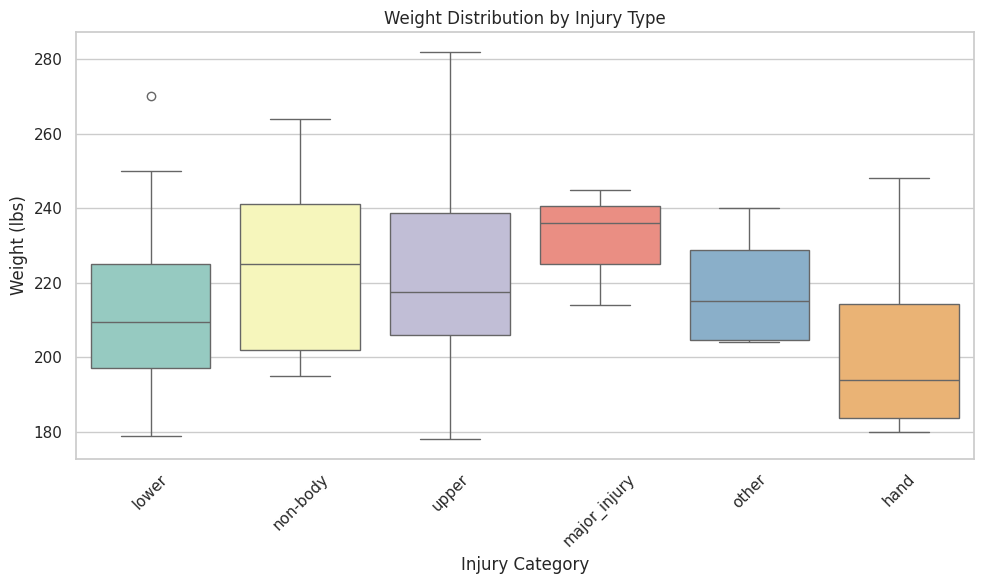

✅ Saved clean version with merged height/weight and injury severity.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Load original dataset
df = pd.read_csv("Top10Players_WithRealInjuryDurations.csv")

#Classify injury severity based on DaysInjuredReal
def classify_severity(days):
    if days == 0:
        return "None"
    elif days <= 7:
        return "Minor"
    elif days <= 14:
        return "Moderate"
    else:
        return "Severe"

df["InjurySeverity"] = df["DaysInjuredReal"].apply(classify_severity)

# STEP 3: Plot distribution of severity classes
severity_counts = df["InjurySeverity"].value_counts().reindex(
    ["None", "Minor", "Moderate", "Severe"], fill_value=0
)

plt.figure(figsize=(8, 5))
sns.barplot(x=severity_counts.index, y=severity_counts.values,
            palette=["#9fc5e8", "#ffd966", "#f6b26b", "#e06666"])
plt.title("Injury Severity Distribution Among Top 300 Players")
plt.xlabel("Injury Severity")
plt.ylabel("Number of Players")
for i, count in enumerate(severity_counts.values):
    plt.text(i, count + 2, str(count), ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.savefig("InjurySeverityAmong300Players.png")
plt.show()

#Merge height & weight
height_df = pd.read_csv("/content/300_NBA_Players_-_Height___Weight.csv")  # <-- exported player height/weight data

# Clean names just in case
height_df["Player"] = height_df["Player"].str.strip()
df["Player"] = df["Player"].str.strip()

# Convert height to inches
def parse_height(h):
    if isinstance(h, str) and "'" in h:
        feet, inches = h.replace('"', '').split("'")
        return int(feet) * 12 + int(inches)
    return None

height_df["Height_in"] = height_df["Height"].apply(parse_height)
height_df["Weight_lb"] = height_df["Weight"].str.replace(" lbs", "").astype(int)

# Drop old columns and keep the numeric ones
height_df = height_df[["Player", "Height_in", "Weight_lb"]]

# Merge into main DataFrame
df = df.merge(height_df, on="Player", how="left")

import seaborn as sns
import matplotlib.pyplot as plt

# Filter out 'returned_from_injury' and focus on main categories
main_categories = ["major_injury", "lower", "upper", "non-body", "hand", "other"]
filtered_df = df[df["InjuryCategories"].isin(main_categories)]

# Plot 1: Height vs Injury Severity
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="InjurySeverity", y="Height_in", palette="pastel")
plt.title("Height Distribution by Injury Severity")
plt.xlabel("Injury Severity")
plt.ylabel("Height (inches)")
plt.tight_layout()
plt.savefig("HeightvsInjury.png")
plt.show()

# Plot 2: Weight vs Injury Severity
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="InjurySeverity", y="Weight_lb", palette="pastel")
plt.title("Weight Distribution by Injury Severity")
plt.xlabel("Injury Severity")
plt.ylabel("Weight (lbs)")
plt.tight_layout()
plt.savefig("WeightvsInjruy.png")
plt.show()

# Plot 3: Height vs Injury Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x="InjuryCategories", y="Height_in", palette="Set2")
plt.title("Height Distribution by Injury Type")
plt.xlabel("Injury Category")
plt.ylabel("Height (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("HeightvsType.png")
plt.show()

# Plot 4: Weight vs Injury Category
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x="InjuryCategories", y="Weight_lb", palette="Set3")
plt.title("Weight Distribution by Injury Type")
plt.xlabel("Injury Category")
plt.ylabel("Weight (lbs)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("WeightvsType.png")
plt.show()




# Normalize height/weight
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[["Height_in_norm", "Weight_lb_norm"]] = scaler.fit_transform(df[["Height_in", "Weight_lb"]])

#Keep preferred features (including new ones)
preferred_cols = [
    "Player", "Age", "MP", "FG%", "3P%", "2P%", "TRB", "AST",
    "STL", "BLK", "TOV", "PF", "PTS", "FT%",
    "DaysInjuredReal", "InjurySeverity", "Pos",
    "Height_in", "Weight_lb", "Height_in_norm", "Weight_lb_norm"
]
df = df[[col for col in preferred_cols if col in df.columns]].dropna()

#Save clean version
df.to_csv("Top10Players_WithRealInjuryDurations_Updated.csv", index=False)
print("✅ Saved clean version with merged height/weight and injury severity.")


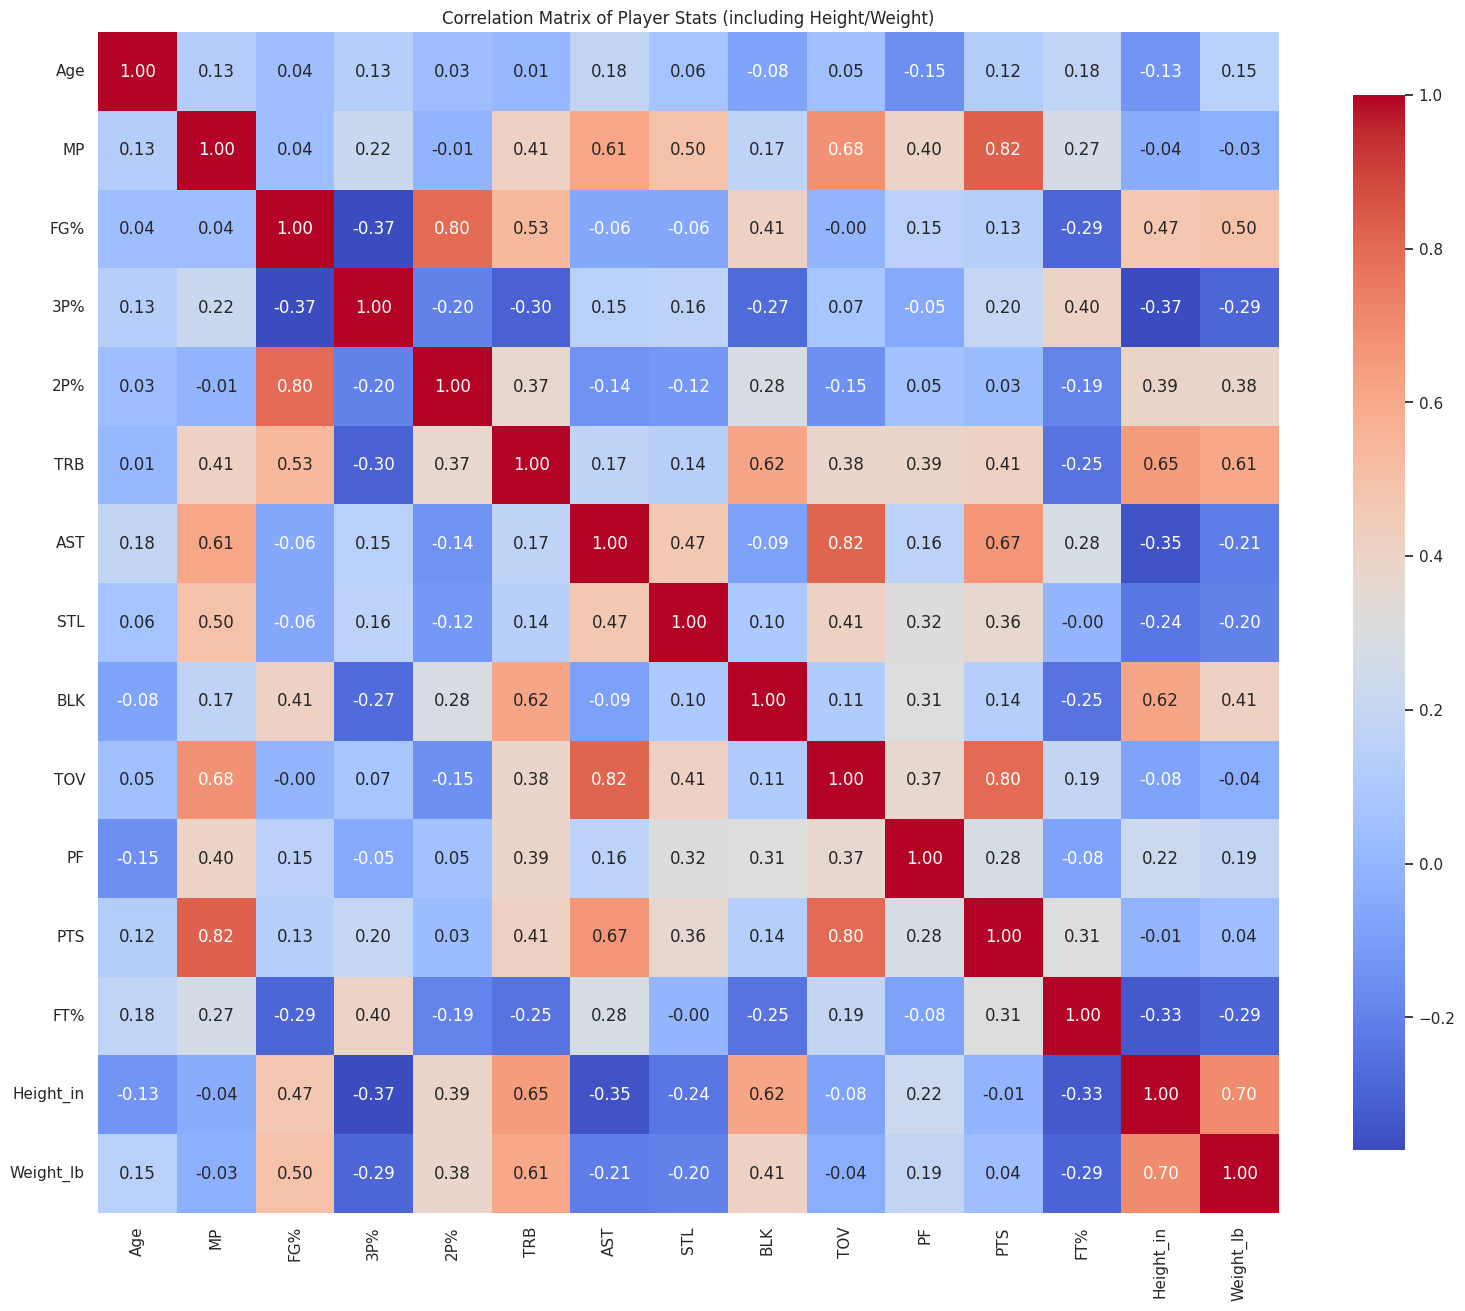

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns relevant to performance and injury
numeric_cols = [
    "Age", "MP", "FG%", "3P%", "2P%",
    "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "FT%",
    "Height_in", "Weight_lb"  # or use "Height_in_norm", "Weight_lb_norm"
]

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix of Player Stats (including Height/Weight)")
plt.tight_layout()
plt.savefig("CorrelationMatrix.png")
plt.show()


<ipython-input-16-2b27a5896608>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="InjurySeverity", y="MP", data=df, palette="Set2")


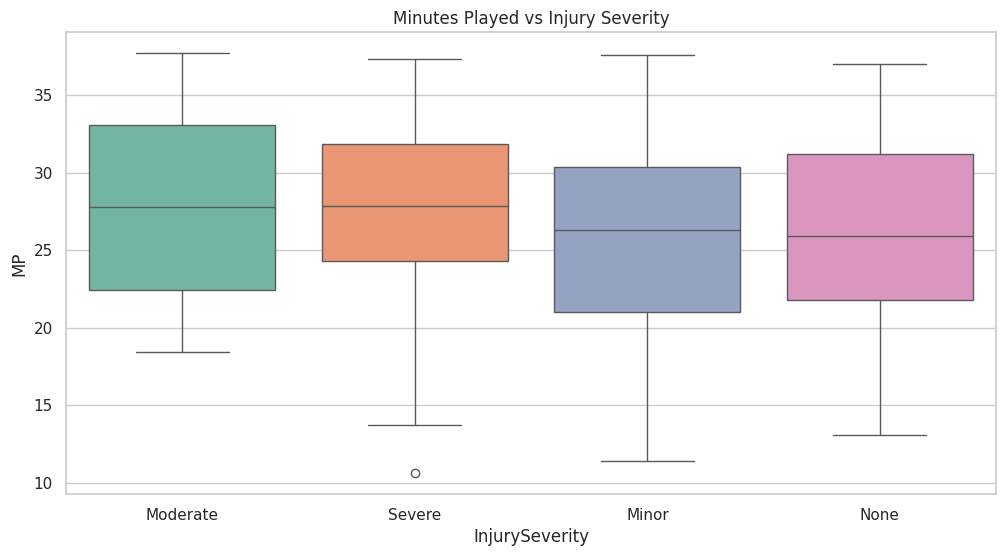

In [ ]:
sns.boxplot(x="InjurySeverity", y="MP", data=df, palette="Set2")
plt.title("Minutes Played vs Injury Severity")
plt.savefig("MinutesvsInjurtySeverity.png")


Text(0.5, 1.0, 'Distribution of Injury Durations (Days)')

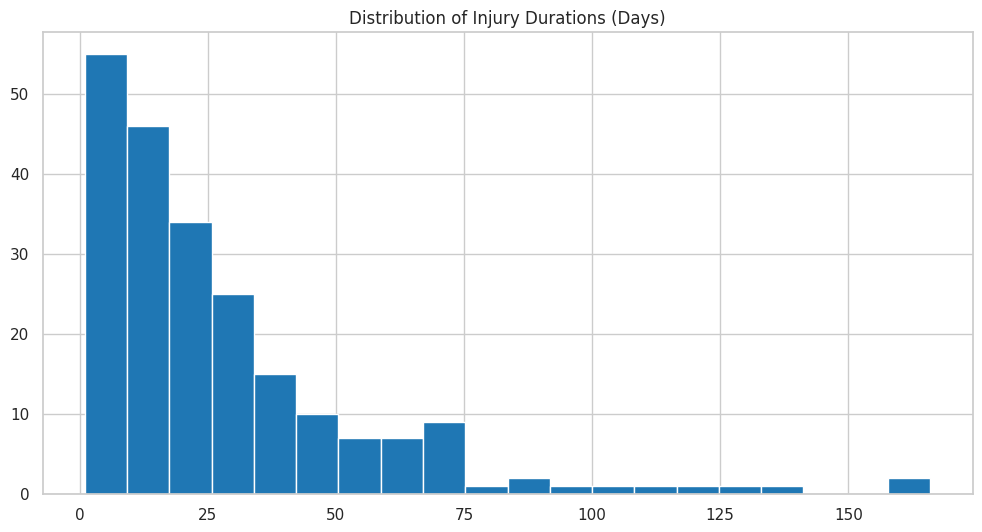

In [ ]:
df[df["DaysInjuredReal"] > 0]["DaysInjuredReal"].hist(bins=20, color="#1f77b4")
plt.title("Distribution of Injury Durations (Days)")



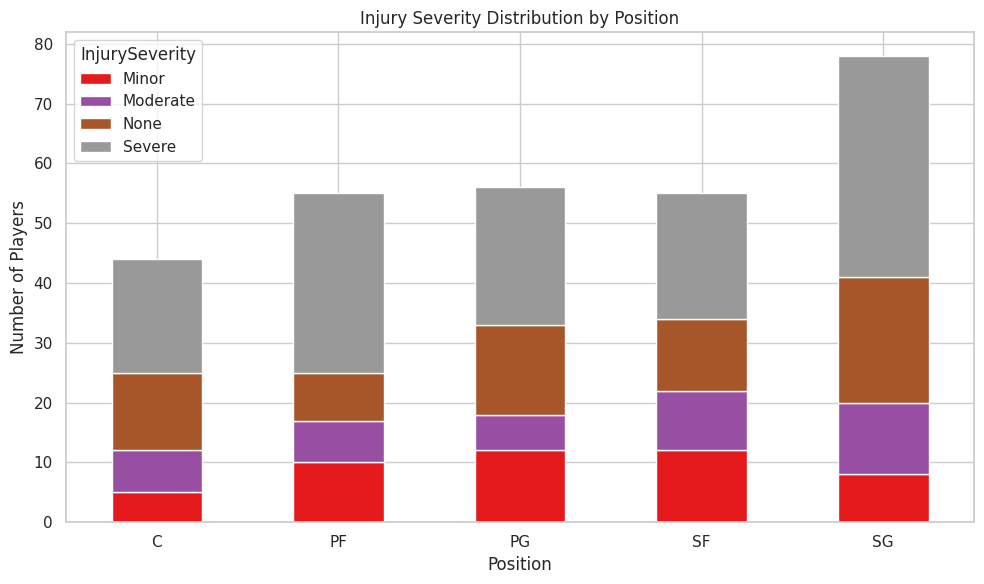

In [ ]:
severity_pos = df.groupby(["Pos", "InjurySeverity"]).size().unstack().fillna(0)

severity_pos.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set1")
plt.title("Injury Severity Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Number of Players")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("InjurtySeverityBy.png")
plt.show()


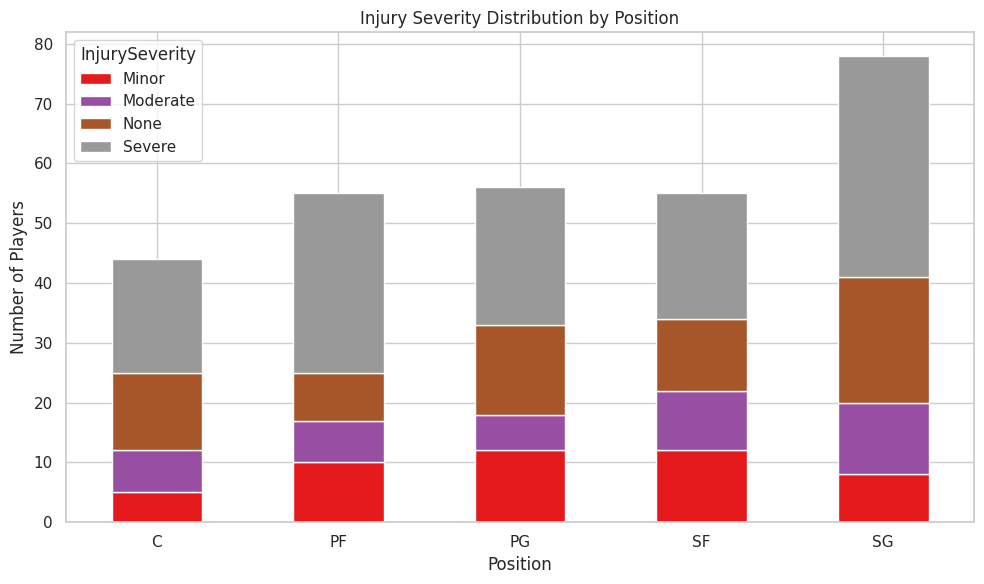

<ipython-input-20-5f013c47e8aa>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_height = df.groupby(["HeightGroup", "InjurySeverity"]).size().unstack().fillna(0)


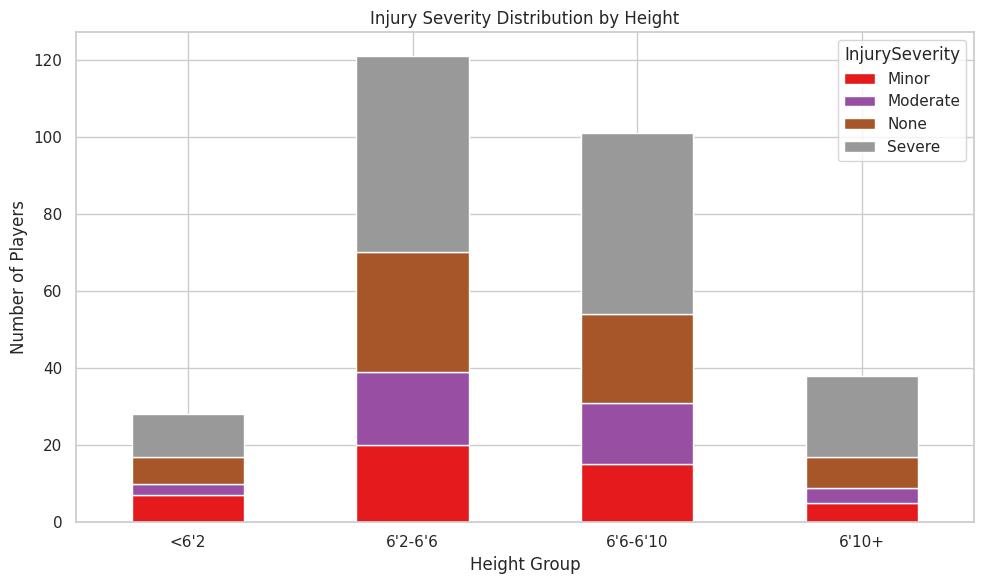

<ipython-input-20-5f013c47e8aa>:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_weight = df.groupby(["WeightGroup", "InjurySeverity"]).size().unstack().fillna(0)


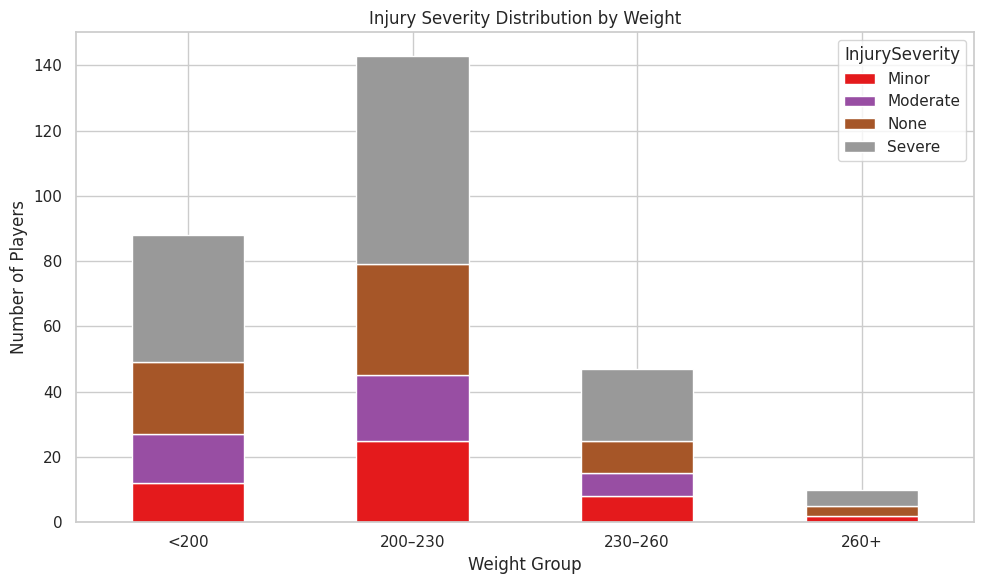

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Severity by Position
severity_pos = df.groupby(["Pos", "InjurySeverity"]).size().unstack().fillna(0)
severity_pos.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set1")
plt.title("Injury Severity Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Number of Players")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("InjurySeverityDisbyPos.png")
plt.show()

#Create Height Buckets
df["HeightGroup"] = pd.cut(df["Height_in"], bins=[70, 74, 78, 82, 90], labels=["<6'2", "6'2-6'6", "6'6-6'10", "6'10+"])

#Severity by Height Group
severity_height = df.groupby(["HeightGroup", "InjurySeverity"]).size().unstack().fillna(0)
severity_height.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set1")
plt.title("Injury Severity Distribution by Height")
plt.xlabel("Height Group")
plt.ylabel("Number of Players")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("InjuryDisbyHeight.png")
plt.show()

#Create Weight Buckets
df["WeightGroup"] = pd.cut(df["Weight_lb"], bins=[160, 200, 230, 260, 300], labels=["<200", "200–230", "230–260", "260+"])

# by Weight Group
severity_weight = df.groupby(["WeightGroup", "InjurySeverity"]).size().unstack().fillna(0)
severity_weight.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="Set1")
plt.title("Injury Severity Distribution by Weight")
plt.xlabel("Weight Group")
plt.ylabel("Number of Players")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("InjuryDisByWeight.png")
plt.show()



🔧 Model 1 with params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        26
           1       0.71      0.77      0.74        26
           2       0.50      0.42      0.46        26
           3       0.56      0.54      0.55        26

    accuracy                           0.64       104
   macro avg       0.63      0.64      0.64       104
weighted avg       0.63      0.64      0.64       104



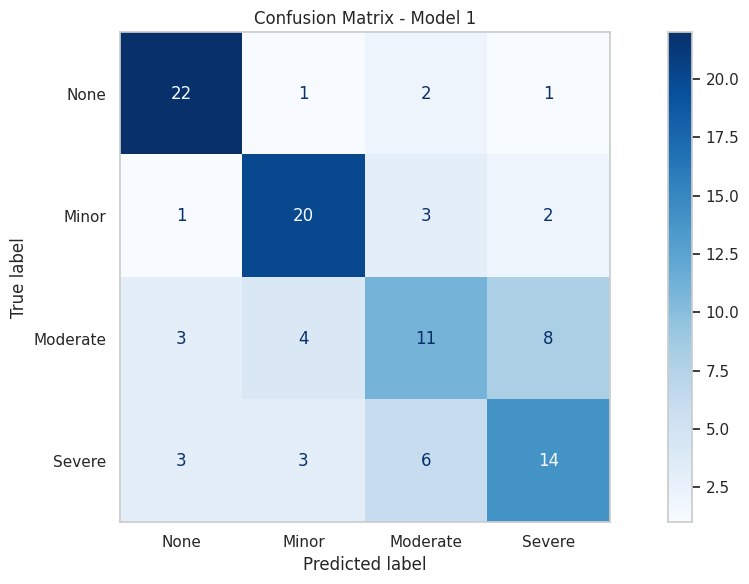

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🔁 Avg CV F1 Score: 0.6525

🔧 Model 2 with params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        26
           1       0.76      0.73      0.75        26
           2       0.55      0.46      0.50        26
           3       0.59      0.62      0.60        26

    accuracy                           0.67       104
   macro avg       0.67      0.67      0.67       104
weighted avg       0.67      0.67      0.67       104



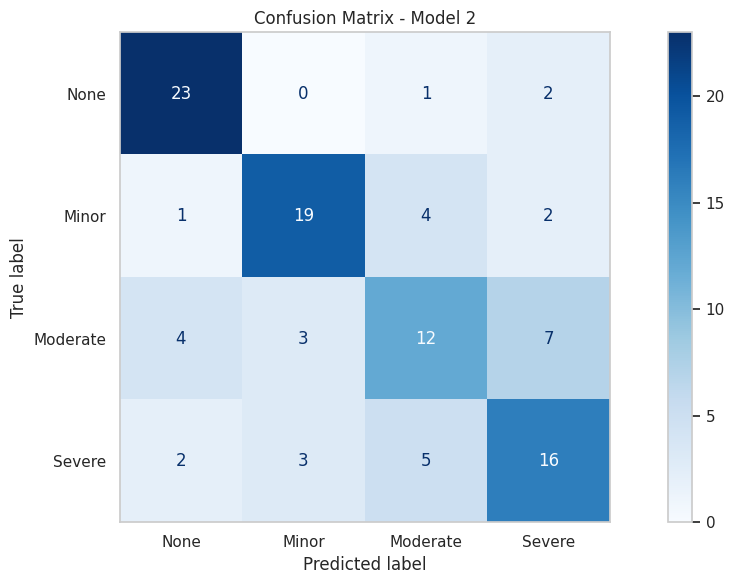

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🔁 Avg CV F1 Score: 0.6749

🔧 Model 3 with params: {'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.83      0.77      0.80        26
           2       0.60      0.46      0.52        26
           3       0.62      0.69      0.65        26

    accuracy                           0.71       104
   macro avg       0.71      0.71      0.70       104
weighted avg       0.71      0.71      0.70       104



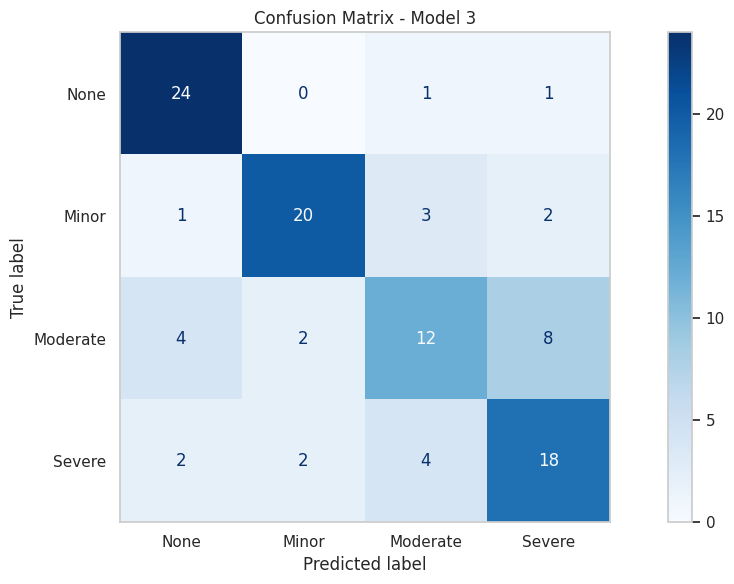

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🔁 Avg CV F1 Score: 0.6996

🔧 Model 4 with params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        26
           1       0.75      0.81      0.78        26
           2       0.50      0.42      0.46        26
           3       0.64      0.62      0.63        26

    accuracy                           0.67       104
   macro avg       0.66      0.67      0.67       104
weighted avg       0.66      0.67      0.67       104



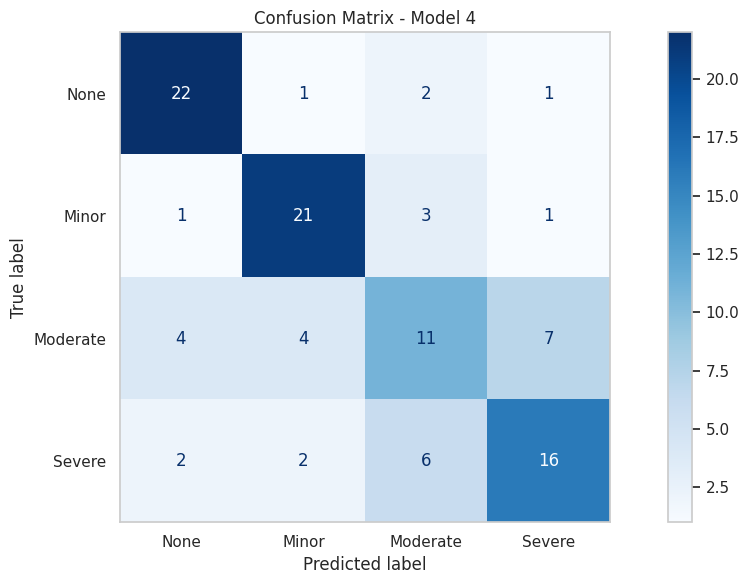

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔁 Avg CV F1 Score: 0.6689

✅ Results saved to 'xgb_hyperparam_results.csv'

🏆 Best Model Parameters:
{'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300}
🔝 Best Weighted F1 Score: 0.6996


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

#Load and copy data
df = pd.read_csv("Top10Players_WithRealInjuryDurations_Updated.csv")
df_players = df[["Player"]].copy()

#Preprocessing function
def prepare_model_data(df, target_col=None):
    df = df.copy()

    # Drop unwanted columns including normalized ones
    drop_cols = [
        "Player", "Player-additional", "InjuryCategories", "Awards", "DaysInjuredReal",
        "Height_in_norm", "Weight_lb_norm", "Pos"
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Fill missing numeric values
    df = df.fillna(df.median(numeric_only=True))

    # Encode categorical variables
    for col in ["Team", "Pos", "InjurySeverity"]:
        if col in df.columns and (df[col].dtype == "object" or str(df[col].dtype).startswith("category")):
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])

    # Separate features and target
    if target_col:
        y = df[target_col]
        X = df.drop(columns=[target_col])
        return X, y
    else:
        return df, None

# Prepare features
X, y = prepare_model_data(df, target_col="InjurySeverity")
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Parameter sets to test
param_sets = [
    {"learning_rate": 0.1, "max_depth": 3, "n_estimators": 100},
    {"learning_rate": 0.05, "max_depth": 4, "n_estimators": 200},
    {"learning_rate": 0.03, "max_depth": 5, "n_estimators": 300},
    {"learning_rate": 0.2, "max_depth": 3, "n_estimators": 100},
]

#Loop through parameter sets and store results
results = []
best_model = None
best_score = -1
best_params = None

for i, params in enumerate(param_sets):
    print(f"\n🔧 Model {i+1} with params: {params}")

    sm = SMOTE(k_neighbors=3, random_state=42)
    X_res, y_res = sm.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)

    model = XGBClassifier(
        **params,
        use_label_encoder=False,
        eval_metric="mlogloss",
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("📊 Classification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["None", "Minor", "Moderate", "Severe"])
    disp.plot(cmap="Blues")
    plt.grid(False)
    plt.title(f"Confusion Matrix - Model {i+1}")
    plt.tight_layout()
    plt.savefig(f"ConfusionMatrix_Model{i}.png")
    plt.show()

    # Cross-validation
    scores = cross_val_score(model, X_res, y_res, cv=5, scoring="f1_weighted")
    avg_score = scores.mean()
    print(f"🔁 Avg CV F1 Score: {avg_score:.4f}")

    # Save results
    results.append({
        "Model": f"Model_{i+1}",
        "Params": params,
        "F1_Weighted_CV": avg_score,
        "Precision_Severe": report['3']['precision'],
        "Recall_Severe": report['3']['recall'],
        "F1_Severe": report['3']['f1-score']
    })

    if avg_score > best_score:
        best_score = avg_score
        best_model = model
        best_params = params

# === Step 6: Save and show best
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_hyperparam_results.csv", index=False)
print("\n✅ Results saved to 'xgb_hyperparam_results.csv'")

print("\n🏆 Best Model Parameters:")
print(best_params)
print(f"🔝 Best Weighted F1 Score: {best_score:.4f}")


In [ ]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X, y)

# SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Create bar plot and capture the figure object
plt.figure()
shap.summary_plot(shap_values, X, plot_type="bar", show=False)  # <- prevent it from displaying
plt.tight_layout()
plt.savefig("shap_feature_importance_bar.png", dpi=300, bbox_inches='tight')
plt.close()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import shap
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

#Train model on full data
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X, y)

#Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X)

#Class labels (must match model encoding)
class_names = ["None", "Minor", "Moderate", "Severe"]

#Plot and save SHAP summary per class
for class_idx, class_name in enumerate(class_names):
    print(f"🔍 Saving SHAP summary for class: {class_name}")
    plt.figure()
    shap.summary_plot(shap_values[..., class_idx], X, plot_type="dot", show=False)
    plt.tight_layout()
    plt.savefig(f"shap_summary_{class_name}.png", dpi=300)
    plt.close()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:04:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔍 Saving SHAP summary for class: None
🔍 Saving SHAP summary for class: Minor
🔍 Saving SHAP summary for class: Moderate
🔍 Saving SHAP summary for class: Severe



🎯 Player: Georges Niang (Index 6) — Predicted Class: None
  None: 98.57%
  Minor: 0.16%
  Moderate: 1.04%
  Severe: 0.24%


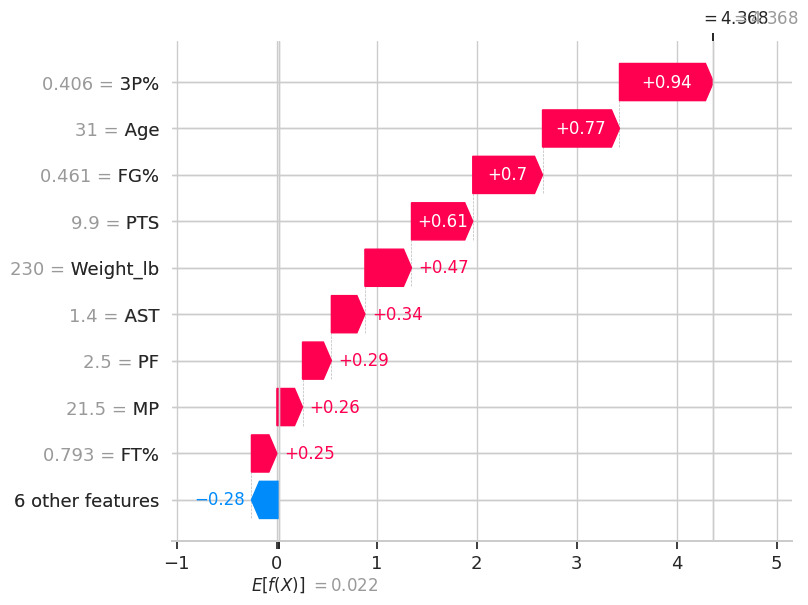


🎯 Player: Jayson Tatum (Index 10) — Predicted Class: None
  None: 95.74%
  Minor: 0.89%
  Moderate: 2.51%
  Severe: 0.86%


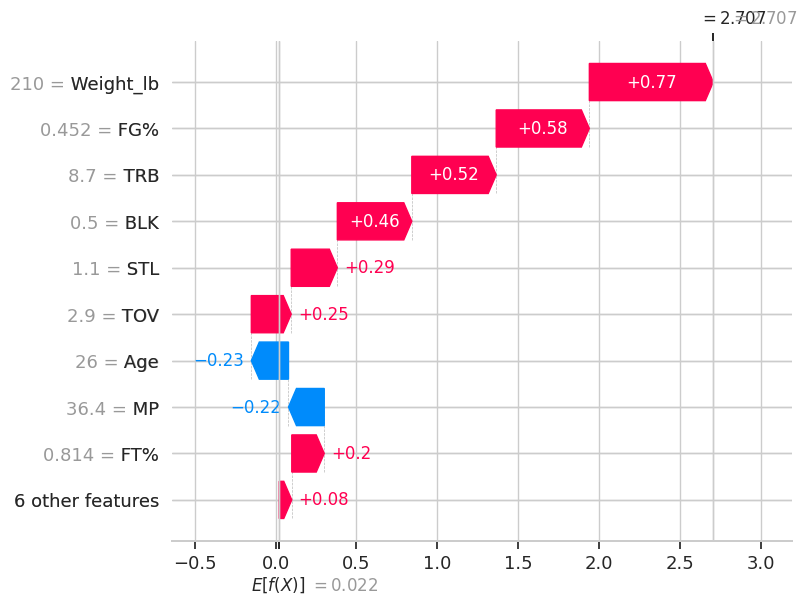


🎯 Player: Derrick White (Index 12) — Predicted Class: None
  None: 97.05%
  Minor: 1.49%
  Moderate: 0.84%
  Severe: 0.62%


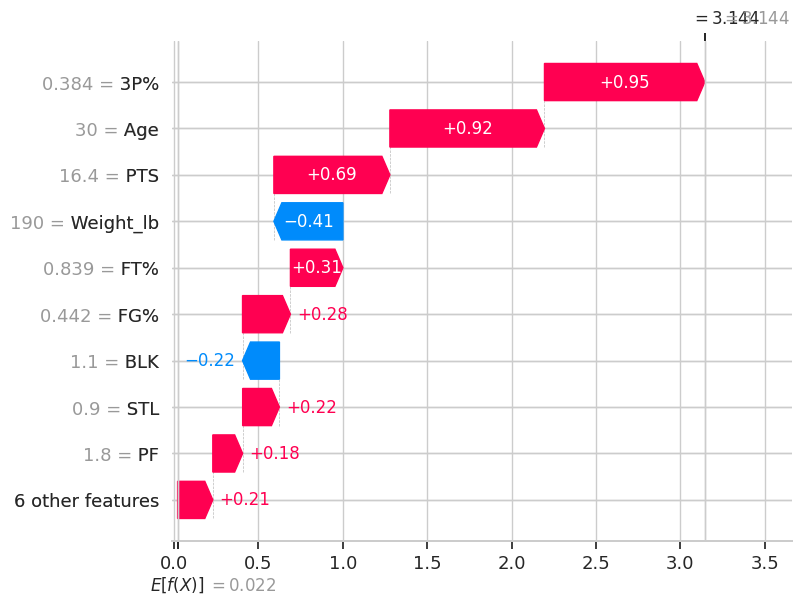


🎯 Player: Payton Pritchard (Index 15) — Predicted Class: None
  None: 98.01%
  Minor: 0.32%
  Moderate: 1.32%
  Severe: 0.35%


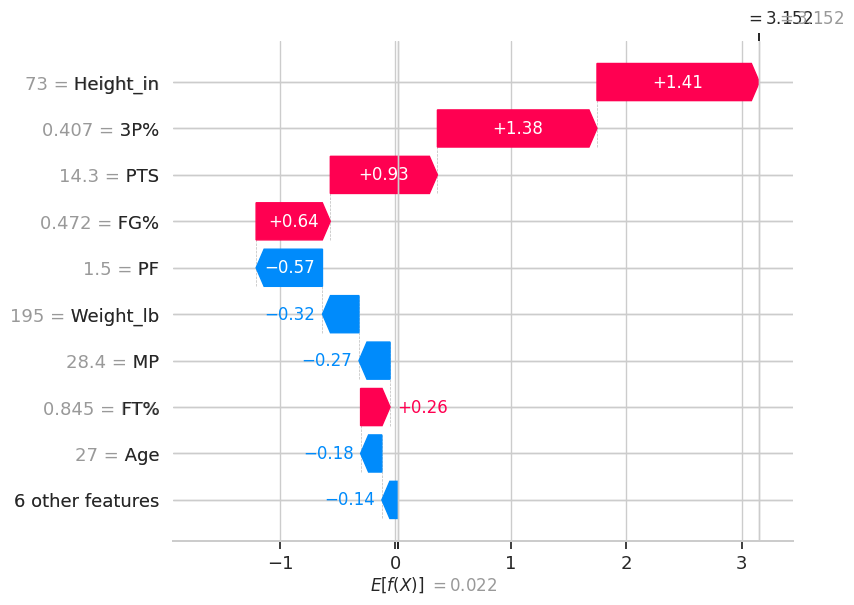


🎯 Player: Luke Kornet (Index 18) — Predicted Class: None
  None: 93.26%
  Minor: 0.25%
  Moderate: 2.94%
  Severe: 3.55%


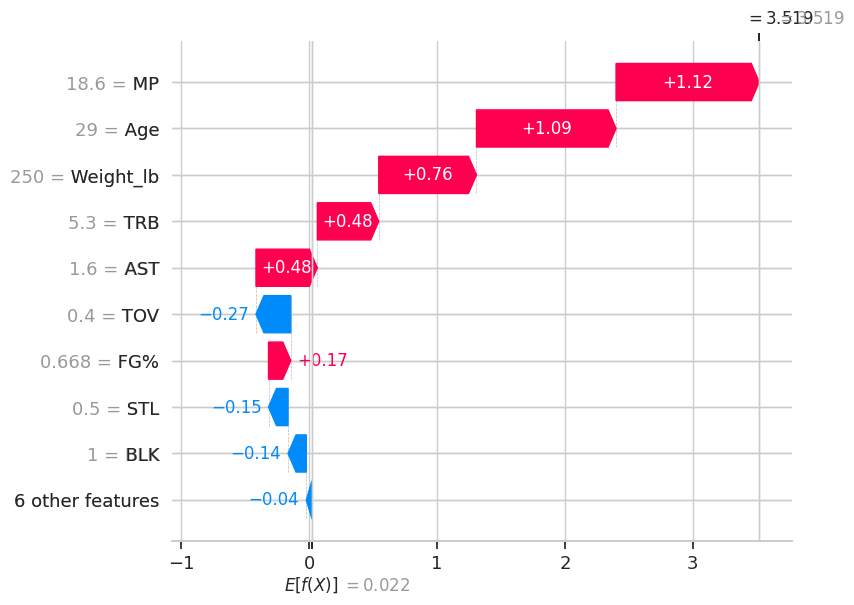


🎯 Player: Jalen Wilson (Index 25) — Predicted Class: None
  None: 96.94%
  Minor: 0.22%
  Moderate: 1.31%
  Severe: 1.53%


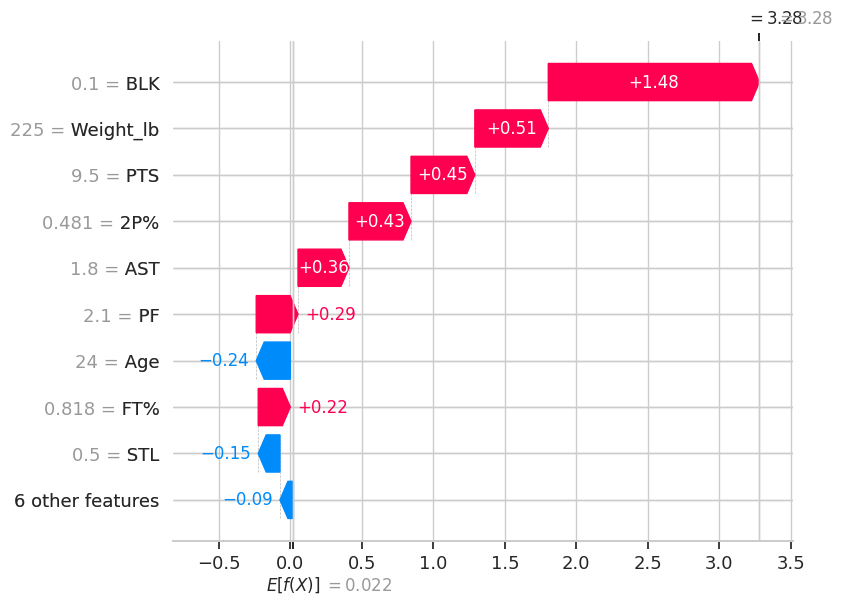


🎯 Player: Matas Buzelis (Index 38) — Predicted Class: None
  None: 96.11%
  Minor: 0.44%
  Moderate: 2.99%
  Severe: 0.46%


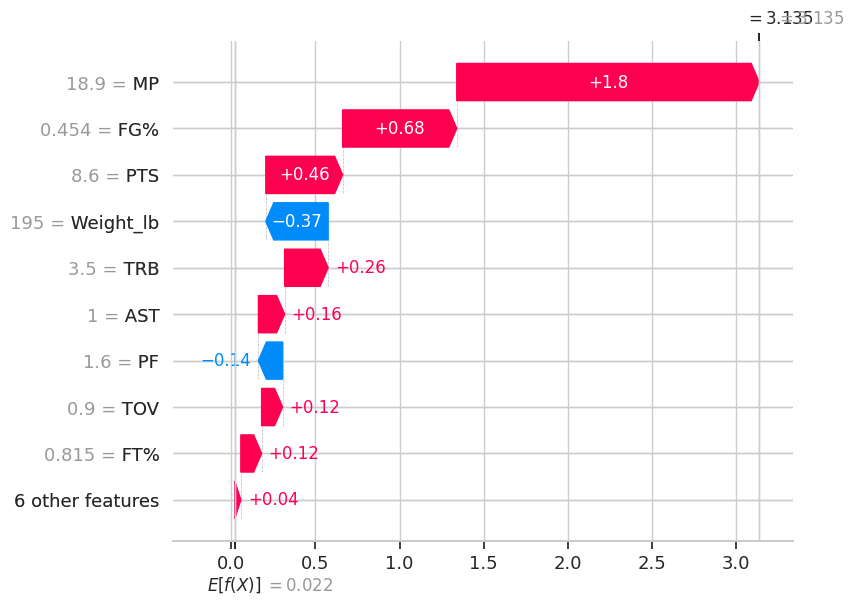


🎯 Player: Zach Collins (Index 39) — Predicted Class: None
  None: 97.18%
  Minor: 0.51%
  Moderate: 1.06%
  Severe: 1.24%


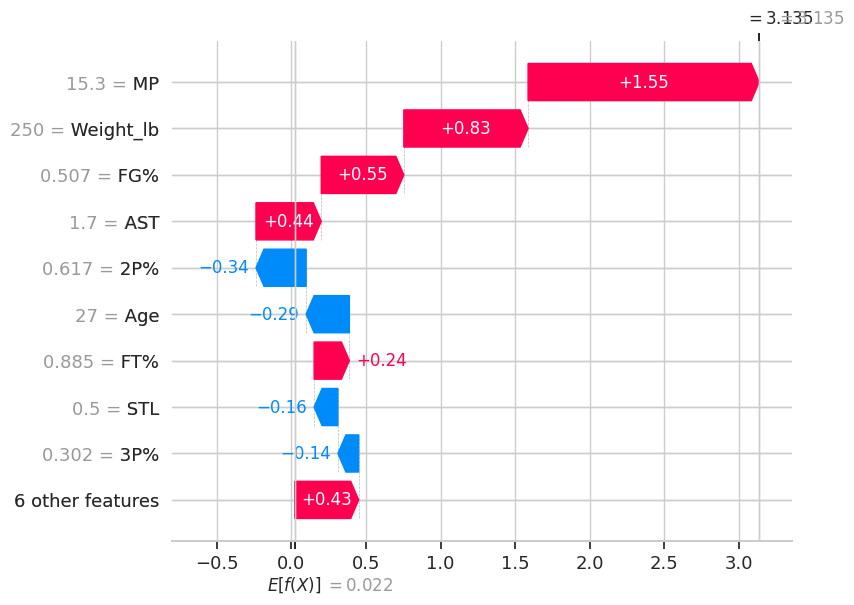


🎯 Player: Damion Baugh (Index 46) — Predicted Class: None
  None: 97.20%
  Minor: 0.45%
  Moderate: 1.02%
  Severe: 1.33%


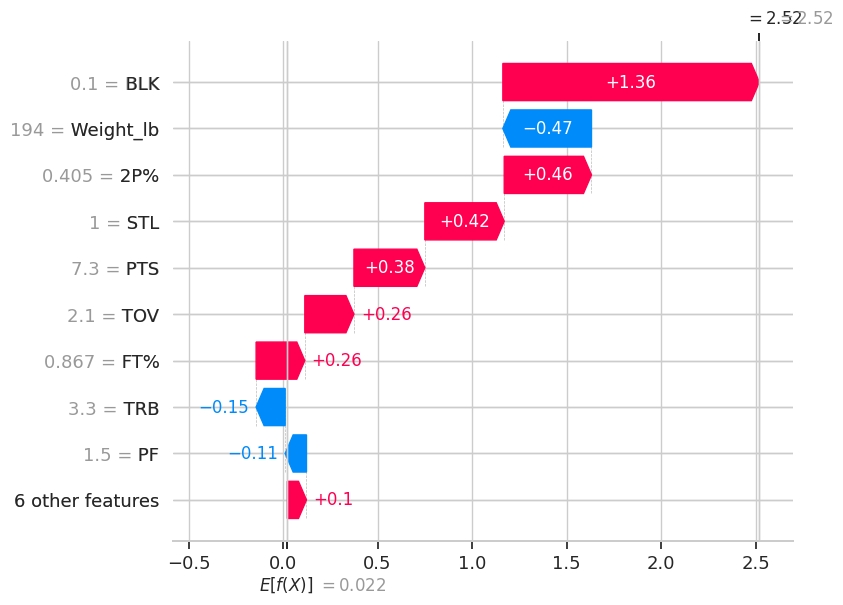


🎯 Player: Tre Mann (Index 47) — Predicted Class: None
  None: 97.17%
  Minor: 0.48%
  Moderate: 1.30%
  Severe: 1.05%


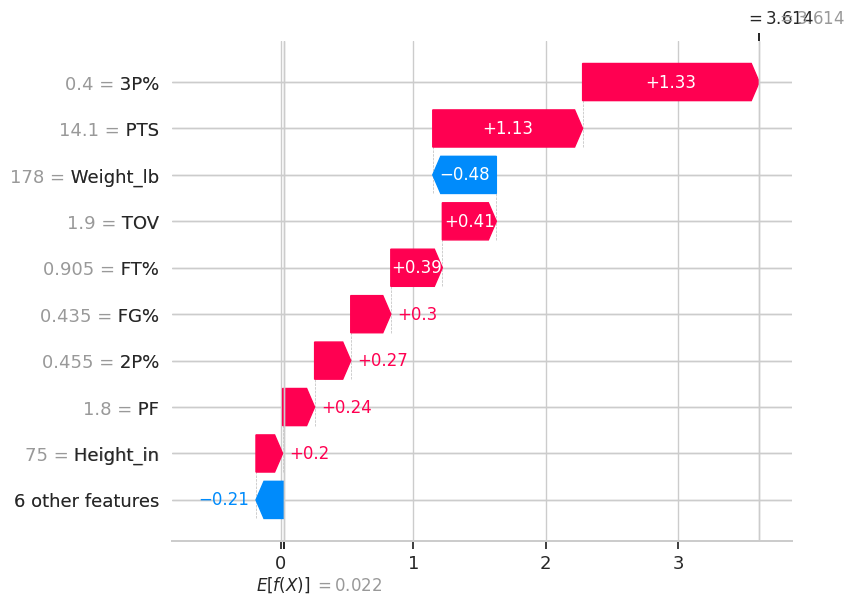

In [ ]:
import shap

#Predict class labels and probabilities
probas_all = model.predict_proba(X)
predicted_classes = probas_all.argmax(axis=1)

#Select class to visualize
class_id = 0  # 🔁 Change this to 0=None, 1=Minor, 2=Moderate, 3=Severe
class_name = ["None", "Minor", "Moderate", "Severe"][class_id]

#Find indices for players predicted in that class
class_indices = [i for i in range(len(predicted_classes)) if predicted_classes[i] == class_id]
selected_idx = class_indices[:10]  # You can use random.sample(...) if preferred

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X.iloc[selected_idx])

#Loop through and explain each player
for i, idx in enumerate(selected_idx):
    # Get name from original dataframe
    player_name = df.loc[idx, "Player"]

    print(f"\n🎯 Player: {player_name} (Index {idx}) — Predicted Class: {class_name}")
    player_proba = probas_all[idx]
    for j, cls in enumerate(["None", "Minor", "Moderate", "Severe"]):
        print(f"  {cls}: {player_proba[j]*100:.2f}%")

    # Show SHAP waterfall plot
    explanation = shap.Explanation(
    values=shap_values[..., class_id].values[i],
    base_values=shap_values[..., class_id].base_values[i],
    data=shap_values[..., class_id].data[i],
    feature_names=X.columns
)

    shap.plots.waterfall(explanation, max_display=10)
    plt.savefig(f"shap_waterfall_{safe_name}_{class_name}.png", dpi=300)



In [ ]:
explanation

.values =
array([ 0.09073988, -0.10191314,  0.30267292,  1.3344045 ,  0.27293023,
        0.01776958, -0.16862878, -0.05483107,  0.00619948,  0.40821174,
        0.24179862,  1.1321574 ,  0.38930055,  0.20116635, -0.48047984],
      dtype=float32)

.base_values =
np.float32(0.02208218)

.data =
array([ 23.   ,  24.5  ,   0.435,   0.4  ,   0.455,   2.9  ,   3.   ,
         0.5  ,   0.3  ,   1.9  ,   1.8  ,  14.1  ,   0.905,  75.   ,
       178.   ])

In [ ]:
import shap
import matplotlib.pyplot as plt

#Predict class labels and probabilities
probas_all = model.predict_proba(X)
predicted_classes = probas_all.argmax(axis=1)

#Select class to visualize
class_id = 1  # 🔁 Change this to 0=None, 1=Minor, 2=Moderate, 3=Severe
class_name = ["None", "Minor", "Moderate", "Severe"][class_id]

#Find indices for players predicted in that class
class_indices = [i for i in range(len(predicted_classes)) if predicted_classes[i] == class_id]
selected_idx = class_indices[:10]  # Or use random.sample(...) if desired

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X.iloc[selected_idx])

#Loop through and explain each player, saving plot
for i, idx in enumerate(selected_idx):
    player_name = df.loc[idx, "Player"]
    print(f"\n🎯 Player: {player_name} (Index {idx}) — Predicted Class: {class_name}")
    player_proba = probas_all[idx]
    for j, cls in enumerate(["None", "Minor", "Moderate", "Severe"]):
        print(f"  {cls}: {player_proba[j]*100:.2f}%")

    # Create SHAP waterfall explanation object
    explanation = shap.Explanation(
    values=shap_values[..., class_id].values[i],
    base_values=shap_values[..., class_id].base_values[i],
    data=shap_values[..., class_id].data[i],
    feature_names=X.columns
)


    # Save plot to file
    plt.figure()
    shap.plots.waterfall(explanation, max_display=10, show=False)
    plt.tight_layout()
    safe_name = player_name.replace(" ", "_").replace("/", "-")
    plt.savefig(f"shap_waterfall_{safe_name}_{class_name}.png", dpi=300)
    plt.close()



🎯 Player: Trae Young (Index 0) — Predicted Class: Minor
  None: 1.05%
  Minor: 96.17%
  Moderate: 1.70%
  Severe: 1.08%

🎯 Player: Dyson Daniels (Index 2) — Predicted Class: Minor
  None: 0.75%
  Minor: 97.06%
  Moderate: 0.64%
  Severe: 1.55%

🎯 Player: Onyeka Okongwu (Index 3) — Predicted Class: Minor
  None: 0.50%
  Minor: 97.08%
  Moderate: 1.52%
  Severe: 0.91%

🎯 Player: Zaccharie Risacher (Index 5) — Predicted Class: Minor
  None: 0.32%
  Minor: 98.07%
  Moderate: 1.53%
  Severe: 0.09%

🎯 Player: Clint Capela (Index 7) — Predicted Class: Minor
  None: 0.46%
  Minor: 95.06%
  Moderate: 3.44%
  Severe: 1.03%

🎯 Player: Al Horford (Index 16) — Predicted Class: Minor
  None: 0.71%
  Minor: 95.64%
  Moderate: 2.07%
  Severe: 1.58%

🎯 Player: Sam Hauser (Index 17) — Predicted Class: Minor
  None: 0.32%
  Minor: 96.54%
  Moderate: 2.31%
  Severe: 0.83%

🎯 Player: Coby White (Index 30) — Predicted Class: Minor
  None: 0.27%
  Minor: 97.73%
  Moderate: 0.95%
  Severe: 1.06%

🎯 Player: M

In [ ]:
import shap
import matplotlib.pyplot as plt

#Predict class labels and probabilities
probas_all = model.predict_proba(X)
predicted_classes = probas_all.argmax(axis=1)

#Select class to visualize
class_id = 2  # 🔁 Change this to 0=None, 1=Minor, 2=Moderate, 3=Severe
class_name = ["None", "Minor", "Moderate", "Severe"][class_id]

#Find indices for players predicted in that class
class_indices = [i for i in range(len(predicted_classes)) if predicted_classes[i] == class_id]
selected_idx = class_indices[:10]  # You can use random.sample(...) if preferred

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X.iloc[selected_idx])

#Loop through and explain each player
for i, idx in enumerate(selected_idx):
    player_name = df.loc[idx, "Player"]
    print(f"\n🎯 Player: {player_name} (Index {idx}) — Predicted Class: {class_name}")
    player_proba = probas_all[idx]
    for j, cls in enumerate(["None", "Minor", "Moderate", "Severe"]):
        print(f"  {cls}: {player_proba[j]*100:.2f}%")

    # Create explanation object
    explanation = shap.Explanation(
    values=shap_values[..., class_id].values[i],
    base_values=shap_values[..., class_id].base_values[i],
    data=shap_values[..., class_id].data[i],
    feature_names=X.columns
)

    # Save waterfall plot
    plt.figure()
    shap.plots.waterfall(explanation, max_display=10, show=False)
    plt.tight_layout()
    safe_name = player_name.replace(" ", "_").replace("/", "-")
    plt.savefig(f"shap_waterfall_{safe_name}_{class_name}.png", dpi=300)
    plt.close()



🎯 Player: Jalen Johnson (Index 1) — Predicted Class: Moderate
  None: 0.14%
  Minor: 1.20%
  Moderate: 97.54%
  Severe: 1.11%

🎯 Player: Caris LeVert (Index 4) — Predicted Class: Moderate
  None: 0.24%
  Minor: 0.21%
  Moderate: 98.61%
  Severe: 0.94%

🎯 Player: Vit Krejci (Index 9) — Predicted Class: Moderate
  None: 0.36%
  Minor: 0.44%
  Moderate: 98.69%
  Severe: 0.51%

🎯 Player: Jaylen Brown (Index 11) — Predicted Class: Moderate
  None: 0.62%
  Minor: 0.15%
  Moderate: 98.55%
  Severe: 0.68%

🎯 Player: Jrue Holiday (Index 13) — Predicted Class: Moderate
  None: 0.06%
  Minor: 1.40%
  Moderate: 98.14%
  Severe: 0.40%

🎯 Player: Cameron Johnson (Index 20) — Predicted Class: Moderate
  None: 0.41%
  Minor: 1.16%
  Moderate: 98.23%
  Severe: 0.20%

🎯 Player: D'Angelo Russell (Index 26) — Predicted Class: Moderate
  None: 0.35%
  Minor: 0.77%
  Moderate: 98.62%
  Severe: 0.26%

🎯 Player: Ziaire Williams (Index 27) — Predicted Class: Moderate
  None: 0.26%
  Minor: 0.27%
  Moderate: 9

In [ ]:
import shap
import matplotlib.pyplot as plt

#Predict class labels and probabilities
probas_all = model.predict_proba(X)
predicted_classes = probas_all.argmax(axis=1)

#Select class to visualize
class_id = 3  #Change this to 0=None, 1=Minor, 2=Moderate, 3=Severe
class_name = ["None", "Minor", "Moderate", "Severe"][class_id]

#Find indices for players predicted in that class
class_indices = [i for i in range(len(predicted_classes)) if predicted_classes[i] == class_id]
selected_idx = class_indices[:10]  # You can use random.sample(...) if preferred

#Get SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X.iloc[selected_idx])

#Loop through and explain each player
for i, idx in enumerate(selected_idx):
    player_name = df.loc[idx, "Player"]

    print(f"\n🎯 Player: {player_name} (Index {idx}) — Predicted Class: {class_name}")
    player_proba = probas_all[idx]
    for j, cls in enumerate(["None", "Minor", "Moderate", "Severe"]):
        print(f"  {cls}: {player_proba[j]*100:.2f}%")

    # Create SHAP explanation
    explanation = shap.Explanation(
    values=shap_values[..., class_id].values[i],
    base_values=shap_values[..., class_id].base_values[i],
    data=shap_values[..., class_id].data[i],
    feature_names=X.columns
)

    # Save waterfall plot
    plt.figure()
    shap.plots.waterfall(explanation, max_display=10, show=False)
    plt.tight_layout()
    safe_name = player_name.replace(" ", "_").replace("/", "-")
    plt.savefig(f"shap_waterfall_{safe_name}_{class_name}.png", dpi=300)
    plt.close()



🎯 Player: Terance Mann (Index 8) — Predicted Class: Severe
  None: 0.18%
  Minor: 1.20%
  Moderate: 1.42%
  Severe: 97.20%

🎯 Player: Kristaps Porziņģis (Index 14) — Predicted Class: Severe
  None: 0.87%
  Minor: 0.35%
  Moderate: 2.48%
  Severe: 96.30%

🎯 Player: Neemias Queta (Index 19) — Predicted Class: Severe
  None: 0.97%
  Minor: 0.14%
  Moderate: 2.74%
  Severe: 96.16%

🎯 Player: Cam Thomas (Index 21) — Predicted Class: Severe
  None: 2.12%
  Minor: 1.82%
  Moderate: 0.92%
  Severe: 95.15%

🎯 Player: Drew Timme (Index 22) — Predicted Class: Severe
  None: 0.12%
  Minor: 0.20%
  Moderate: 1.85%
  Severe: 97.82%

🎯 Player: Killian Hayes (Index 23) — Predicted Class: Severe
  None: 1.06%
  Minor: 0.28%
  Moderate: 1.47%
  Severe: 97.19%

🎯 Player: Nic Claxton (Index 24) — Predicted Class: Severe
  None: 0.10%
  Minor: 0.55%
  Moderate: 1.69%
  Severe: 97.66%

🎯 Player: Keon Johnson (Index 28) — Predicted Class: Severe
  None: 0.26%
  Minor: 0.08%
  Moderate: 1.49%
  Severe: 98.17

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=334938da0c4dd35301f3c1fec6e3d97ed07fbe82cb92249909926519c7d59983
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd

# Make sure X_test is a DataFrame with original features
# Make sure best_model is already trained

# Re-initialize LIME with unscaled training data
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["None", "Minor", "Moderate", "Severe"],
    mode="classification",
    discretize_continuous=True
)

# Predict probabilities for all test instances
pred_probs = best_model.predict_proba(X_test)
pred_classes = pred_probs.argmax(axis=1)

# Pick one sample from each predicted class
found_classes = set()
selected_indices = []

for i, cls in enumerate(pred_classes):
    if cls not in found_classes:
        selected_indices.append(i)
        found_classes.add(cls)
    if len(found_classes) == 4:
        break

# Run LIME on selected examples
for i in selected_indices:
    raw_instance = X_test.iloc[i].values
    proba = best_model.predict_proba([raw_instance])[0]
    pred_class_idx = np.argmax(proba)
    pred_class_name = ["None", "Minor", "Moderate", "Severe"][pred_class_idx]

    print(f"\n🎯 Player #{i} — Predicted Class: {pred_class_name}")
    for cls, p in zip(["None", "Minor", "Moderate", "Severe"], proba):
        print(f"{cls}: {p:.2%}")

    lime_exp = lime_explainer.explain_instance(
        raw_instance,
        best_model.predict_proba,
        num_features=10,
        labels=(pred_class_idx,)
    )

    filename = f"lime_explanation_Player{i}_{pred_class_name}.html"
    lime_exp.save_to_file(filename)
    print(f"💾 Saved explanation to {filename}")



🎯 Player #0 — Predicted Class: Minor
None: 2.18%
Minor: 85.53%
Moderate: 5.71%
Severe: 6.58%
💾 Saved explanation to lime_explanation_Player0_Minor.html

🎯 Player #1 — Predicted Class: None
None: 61.10%
Minor: 19.94%
Moderate: 3.55%
Severe: 15.41%
💾 Saved explanation to lime_explanation_Player1_None.html

🎯 Player #4 — Predicted Class: Moderate
None: 8.43%
Minor: 22.56%
Moderate: 56.30%
Severe: 12.70%
💾 Saved explanation to lime_explanation_Player4_Moderate.html

🎯 Player #5 — Predicted Class: Severe
None: 7.93%
Minor: 8.96%
Moderate: 29.84%
Severe: 53.27%
💾 Saved explanation to lime_explanation_Player5_Severe.html


In [ ]:
!zip -r XAIProject.zip /content/


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.04.21/ (stored 0%)
  adding: content/.config/logs/2025.04.21/18.42.22.411154.log (deflated 58%)
  adding: content/.config/logs/2025.04.21/18.42.31.744939.log (deflated 56%)
  adding: content/.config/logs/2025.04.21/18.42.12.824329.log (deflated 58%)
  adding: content/.config/logs/2025.04.21/18.42.21.235934.log (deflated 86%)
  adding: content/.config/logs/2025.04.21/18.42.31.045496.log (deflated 57%)
  adding: content/.config/logs/2025.04.21/18.41.51.884422.log (deflated 92%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.